In [1]:
import pandas as pd
from sklearn.datasets import load_files
import numpy as np
import os
#!pip3 install opencv-python
import cv2
#!pip install scikit-image
from skimage import data, color
import matplotlib.pyplot as plt

In [2]:
## https://stackoverflow.com/questions/44002577/python-read-multiple-images-from-multiple-folders

def create_dataset(img_folder):
   img_data_array=[]
   class_id=[]
   for dirl in os.listdir(img_folder):
       for file in os.listdir(os.path.join(img_folder,dirl)):
      
           if any([file.endswith(x) for x in ['.png', '.jpeg', '.jpg']]):
                image_path=os.path.join(img_folder,dirl,file)
                image=cv2.imread(image_path,0)
             
                img_data_array.append(image)
                class_id.append(dirl)
   return img_data_array,class_id

def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image,cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

    
train_folder = "data/train/"
img_data, class_id =create_dataset(train_folder)

test_folder = "data/test/"
test_img_data, test_class_id =create_dataset(test_folder)

val_folder = "data/val/"
val_img_data, val_class_id =create_dataset(val_folder)

In [3]:
def extractfeatures(imagedataset):
    Features = []
    for image in imagedataset:
        _feature = np.reshape(image, (48*48))
        Features.append(_feature)
    return Features

def labelType(argument):
    switcher = {
        0: "0 - Angry",
        1: "1 - Disgust",
        2: "2 - Fear",
        3: "3 - Happy",
        4: "4 - Sad",
        5: "5 - Surprise",
        6: "6 - Neutral"
    }
    return switcher.get(argument, "nothing")

In [4]:
# Get training Images Features 
AllFeatures = extractfeatures(img_data)

print('Shape : ',AllFeatures[0].shape)
print('Feature Array : ', AllFeatures[0])

Shape :  (2304,)
Feature Array :  [162 161 159 ... 192 193 196]


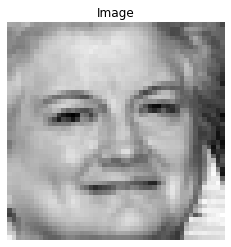

In [5]:
show_image(img_data[0])

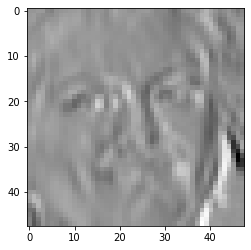

In [6]:
# Edge Features
from skimage import filters  
from matplotlib.pyplot import imshow
import cv2

# prewitt kernel
pre_hor = filters.prewitt_h(img_data[0])
pre_ver = filters.prewitt_v(img_data[0])

# Sobel Kernel
ed_sobel = filters.sobel(img_data[0])

#canny algorithm
can = cv2.Canny(img_data[0],48,48)

imshow(pre_ver, cmap='gray')

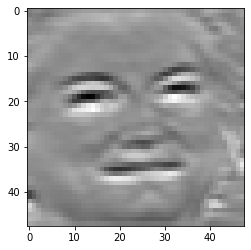

In [7]:
imshow(pre_hor, cmap='gray')

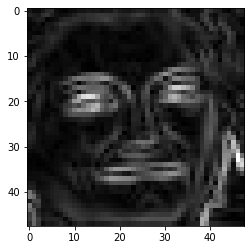

In [8]:
imshow(ed_sobel, cmap="gray")

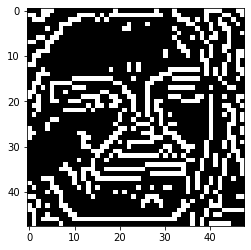

In [9]:
imshow(can, cmap='gray')

In [10]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
param_grid_nb = {
    'var_smoothing':  [1e-11, 1e-10, 1e-9] #np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=2, n_jobs=-1)   #try cv=3  , n_jobs=-1 => all CPUs will be used

nbModel_grid.fit(AllFeatures, class_id)
#Printing the best estimator 
print(nbModel_grid.best_estimator_)



Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.9s finished


GaussianNB(var_smoothing=1e-11)


In [11]:
##Best Estimator                ###GaussianNB(priors=None, var_smoothing=0.00000000001)
GaussianNB(var_smoothing=1e-11)

x_test = extractfeatures(test_img_data)

y_pred = nbModel_grid.predict(x_test)
print(y_pred[:20])


['4' '4' '4' '4' '3' '3' '6' '4' '6' '6' '6' '3' '4' '6' '3' '4' '3' '4'
 '6' '4']


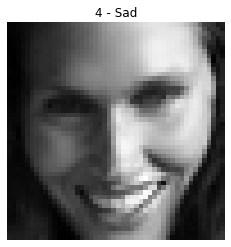

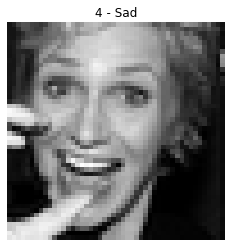

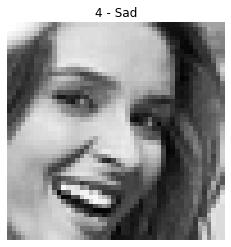

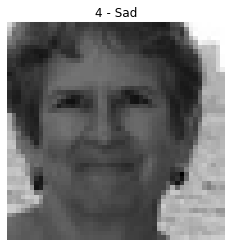

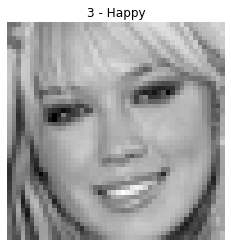

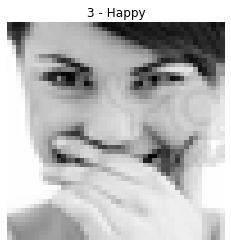

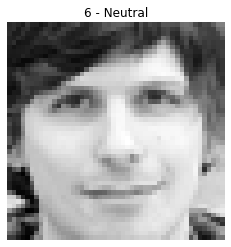

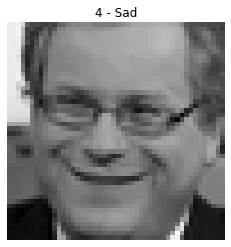

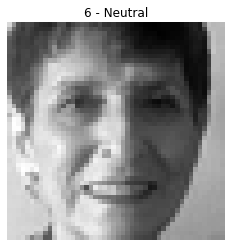

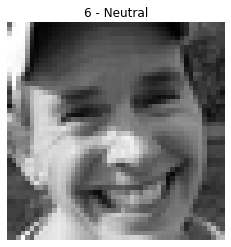

In [12]:
for i in  range(0,10):
    #print("\n" , labelType(int(y_pred[i])))
    show_image(x_test[i].reshape(48, 48), labelType(int(y_pred[i])))

In [13]:
###https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba 

from sklearn.metrics import confusion_matrix , accuracy_score , precision_score , recall_score , f1_score
y_test= test_class_id.copy()
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")
print(accuracy_score(y_test, y_pred), ": is the accuracy score")
print(precision_score(y_test, y_pred,average='weighted'), ": is the precision score")  #None, 'micro', 'macro', 'weighted', 'samples'
print(recall_score(y_test, y_pred,average='weighted'), ": is the recall score")
print(f1_score(y_test, y_pred,average='weighted'), ": is the f1 score")

[[505 262 112]
 [241 283  70]
 [301 217 108]] : is the confusion matrix
0.4268699380657456 : is the accuracy score
0.41815427111515735 : is the precision score
0.4268699380657456 : is the recall score
0.40805332509985826 : is the f1 score


In [14]:
_confusion_matrix = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(_confusion_matrix)
print(cm)
print(type(cm))



     0    1    2
0  505  262  112
1  241  283   70
2  301  217  108
<class 'pandas.core.frame.DataFrame'>


In [15]:
### 

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.values.sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
print("True Positive Ratio = " , TPR)
TNR = TN/(TN+FP) 
print("True Negative Ratio = " , TNR)
PPV = TP/(TP+FP)
print("Precision Score = " , PPV)
NPV = TN/(TN+FN)
print("Negative Score = " , NPV)
FPR = FP/(FP+TN)
print("False Positive Ratio = " , FPR)
FNR = FN/(TP+FN)
print("False Negative Ratio = " , FNR)
FDR = FP/(TP+FP)
print("False Discovery Ratio = " , FDR)

# Overall accuracy 
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy : " , ACC)



True Positive Ratio =  0    0.574516
1    0.476431
2    0.172524
dtype: float64
True Negative Ratio =  0    0.555738
1    0.681728
2    0.876443
dtype: float64
Precision Score =  0    0.482330
1    0.371391
2    0.372414
dtype: float64
Negative Score =  0    0.644487
1    0.767390
2    0.713654
dtype: float64
False Positive Ratio =  0    0.444262
1    0.318272
2    0.123557
dtype: float64
False Negative Ratio =  0    0.425484
1    0.523569
2    0.827476
dtype: float64
False Discovery Ratio =  0    0.517670
1    0.628609
2    0.627586
dtype: float64
Overall Accuracy :  0    0.563602
1    0.623630
2    0.666508
dtype: float64


# Using SVM
########################################

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC

pipeline = Pipeline([
    ('SVM', SVC()), 
])

from sklearn.model_selection import GridSearchCV
param_grid = {'SVM__C': [1]#,2,3,4,5],
                }   
grid = GridSearchCV(pipeline, param_grid, cv=2) 
grid.fit(AllFeatures, class_id)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)



Best cross-validation score: 0.558
Best parameters:  {'SVM__C': 1}


[[559 186 134]
 [ 91 343 160]
 [118 155 353]] : is the confusion matrix
0.5979037636969986 : is the accuracy score
0.6094349183738063 : is the precision score
0.5979037636969986 : is the recall score
0.6015701624123152 : is the f1 score


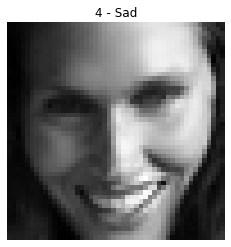

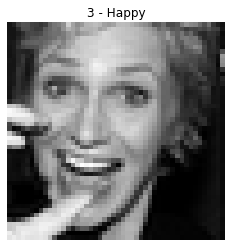

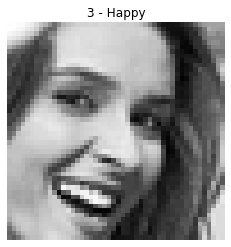

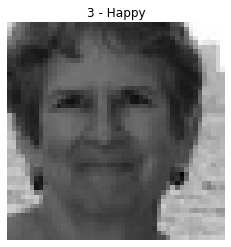

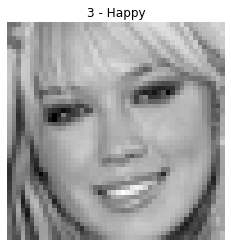

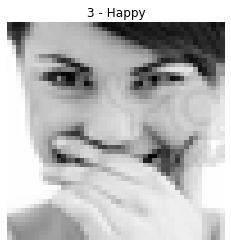

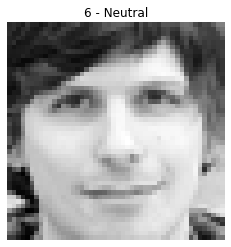

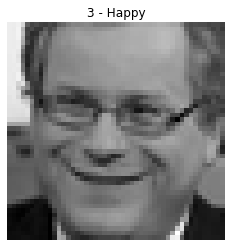

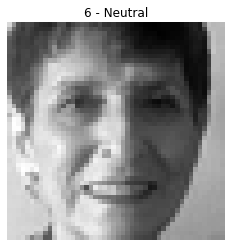

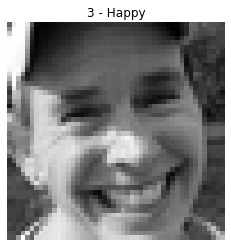

In [17]:
y_test= test_class_id.copy()

x_test = extractfeatures(test_img_data)
y_pred = grid.predict(x_test)

from sklearn.metrics import confusion_matrix , accuracy_score , precision_score , recall_score , f1_score
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")
print(accuracy_score(y_test, y_pred), ": is the accuracy score")
print(precision_score(y_test, y_pred,average='weighted'), ": is the precision score")  
print(recall_score(y_test, y_pred,average='weighted'), ": is the recall score")
print(f1_score(y_test, y_pred,average='weighted'), ": is the f1 score")


for i in  range(0,10):
    #print("\n" , labelType(int(y_pred[i])))
    show_image(x_test[i].reshape(48, 48), labelType(int(y_pred[i])))

# Using Logistic Regression
#######################################

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
                     LogisticRegression(solver='saga'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
    
grid = GridSearchCV(pipe, param_grid, cv=2)
grid.fit(AllFeatures, class_id)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)



C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: T

Best cross-validation score: 0.487
Best parameters:  {'logisticregression__C': 0.01}


C:\Users\jads\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [19]:
from sklearn.metrics import classification_report
############ Validate 
ynew3 = grid.predict(x_test)
print(classification_report(ynew3,y_pred)) ## Validate from Provided Testing Data

              precision    recall  f1-score   support

           3       0.75      0.70      0.72       820
           4       0.55      0.62      0.58       603
           6       0.66      0.63      0.65       676

    accuracy                           0.66      2099
   macro avg       0.65      0.65      0.65      2099
weighted avg       0.66      0.66      0.66      2099



[[526 195 158]
 [148 244 202]
 [146 164 316]] : is the confusion matrix
0.51738923296808 : is the accuracy score
0.5225496757282276 : is the precision score
0.51738923296808 : is the recall score
0.5194360532295899 : is the f1 score


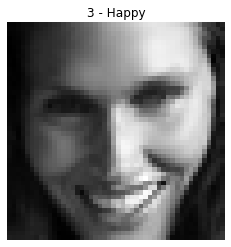

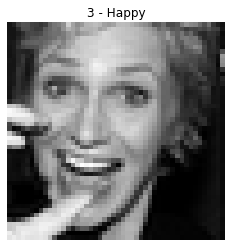

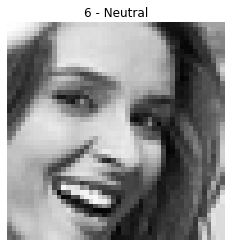

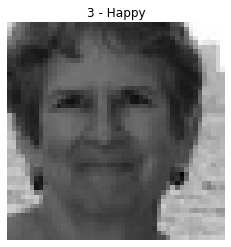

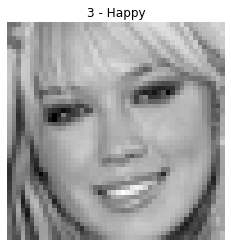

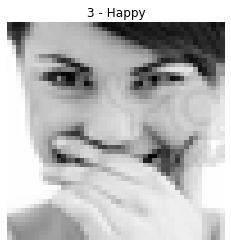

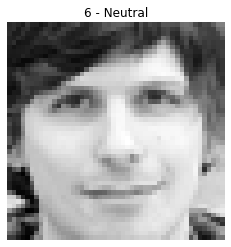

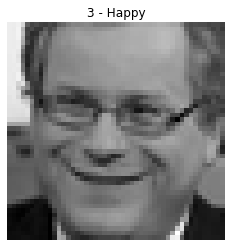

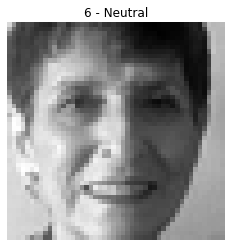

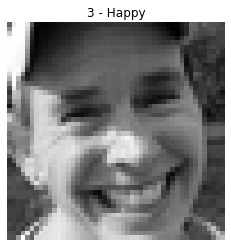

In [20]:
y_pred = grid.predict(x_test)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred), ": is the accuracy score")
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred,average='weighted'), ": is the precision score")  #None, 'micro', 'macro', 'weighted', 'samples'
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred,average='weighted'), ": is the recall score")
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred,average='weighted'), ": is the f1 score")


for i in  range(0,10):
    #print("\n" , labelType(int(y_pred[i])))
    #show_image(x_test[i], labelType(int(y_pred[i])))   # no need to reshape as it is already done up for SVM
    show_image(x_test[i].reshape(48, 48), labelType(int(y_pred[i])))

## Get Random Images with their Predicted Labels

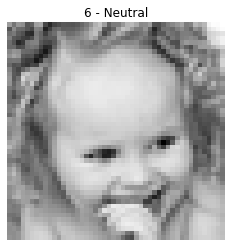

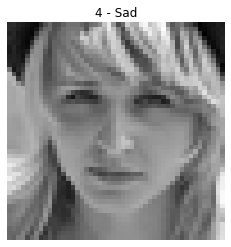

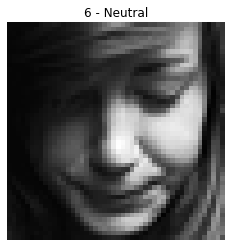

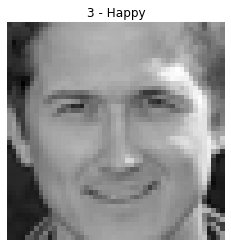

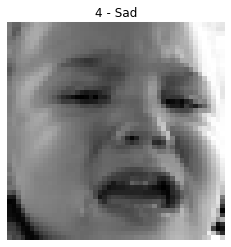

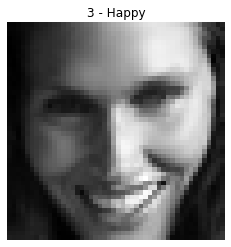

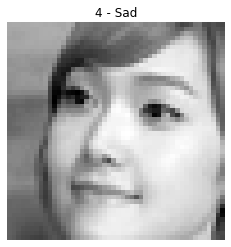

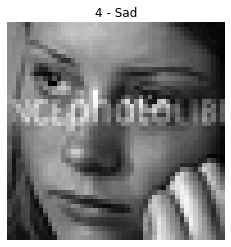

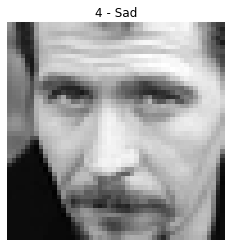

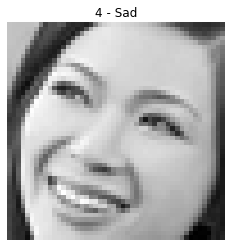

In [21]:
import random
for i in  range(10):
    j=random.randint(0, len(x_test) -1)
    #print("\n" , labelType(int(y_pred[i])))
    #show_image(x_test[i], labelType(int(y_pred[i])))   # no need to reshape as it is already done up for SVM
    show_image(x_test[j].reshape(48, 48), labelType(int(y_pred[j])))